### In this notebook, we apply `popsed` to NSA photometry catalog.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
# popsed.set_matplotlib(style='JL', usetex=False, dpi=80)
from popsed import prior

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [48]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'], 
    device='cuda')

filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
noise = None #'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag_chang.npy'

#### Load NSA photometry catalog

In [49]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [50]:
mags_nsa = np.load('./nsa_sedflow/nsa_mag_data.npy').T
nsa_z = np.load('./nsa_sedflow/nsa_redshift.npy')
nsa_logm = np.load('./nsa_sedflow/nsa_logm_median.npy')

flag = ((mags_nsa[:, 0] - mags_nsa[:, 1]) > 0)
flag &= ((mags_nsa[:, 1] - mags_nsa[:, 2]) > 0)
flag &= ((mags_nsa[:, 1] - mags_nsa[:, 4]) > 0)
flag &= ((mags_nsa[:, 2] - mags_nsa[:, 3]) > 0)
flag &= ((mags_nsa[:, 2] - mags_nsa[:, 4]) > 0)
mags_nsa = mags_nsa[flag][:, :] # no u-band
nsa_z = nsa_z[flag]
nsa_logm = nsa_logm[flag]

# load nsa_sedflow
sedflow_sample = np.load('./nsa_sedflow/nsa_sedflow.posterior.reorganized.npy')
# z_nsa = nsa_z
# z_nsa = nsa_z[nsa_z < 0.03]
# z_nsa = sedflow_sample[:, -2]#[sedflow_sample[:, -2] < 0.03]
# z_nsa = np.random.choice(z_nsa, len(mags_nsa))
# z_nsa = np.random.choice(sedflow_sample[:, -2], len(mags_nsa))
# z_nsa = np.load('./nsa_sedflow/nsa_redshift.npy')[flag]
# mags_nsa = np.load('./reference_catalog/nsa_v101_mag_data.npy')

In [51]:
mags_nsa.shape

(33115, 5)

In [52]:
X_data = torch.Tensor(mags_nsa[:, :])
#X_data = X_data[np.random.choice(np.arange(len(X_data)), 100000)]
print('Total number of samples:', len(X_data))

Total number of samples: 33115


In [53]:
X_data = X_data[nsa_logm < 9.5]
z_nsa = nsa_z[nsa_logm < 9.5]

In [54]:
# X_data = X_data[nsa_z < 0.03]
# z_nsa = nsa_z[nsa_z < 0.03]
# X_data = X_data[nsa_logm < 9.5]

In [55]:
# Determine the intrinsic sampling loss
X_datas = []
for i in range(2):
    ind = np.random.randint(0, len(X_data), 5000)
    X_datas.append(X_data[ind].to('cuda'))
    
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.1, 'scaling': 0.5})
print("Intrinsic sampling loss:", L(X_datas[0], X_datas[1]).item())
intr_loss = L(X_datas[0], X_datas[1]).item()
# Intrinsic sampling loss: 0.01805417239665985

Intrinsic sampling loss: 0.00955167319625616


In [56]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [57]:
_prior_NDE = speculator.bounds.copy()
# _prior_NDE[:4] = np.array([[0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9]]) # include fburst
# _prior_NDE[4] = np.array([1, 10])

# _prior_NDE[5] = np.array([-2.3, 0.2]) # logzsol
# _prior_NDE[6] = np.array([0.1, 2.9])
# _prior_NDE[7] = np.array([0.1, 2.9])
_prior_NDE[-2] = np.array([0., 0.07])
_prior_NDE[-1] = np.array([7.5, 12.5])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

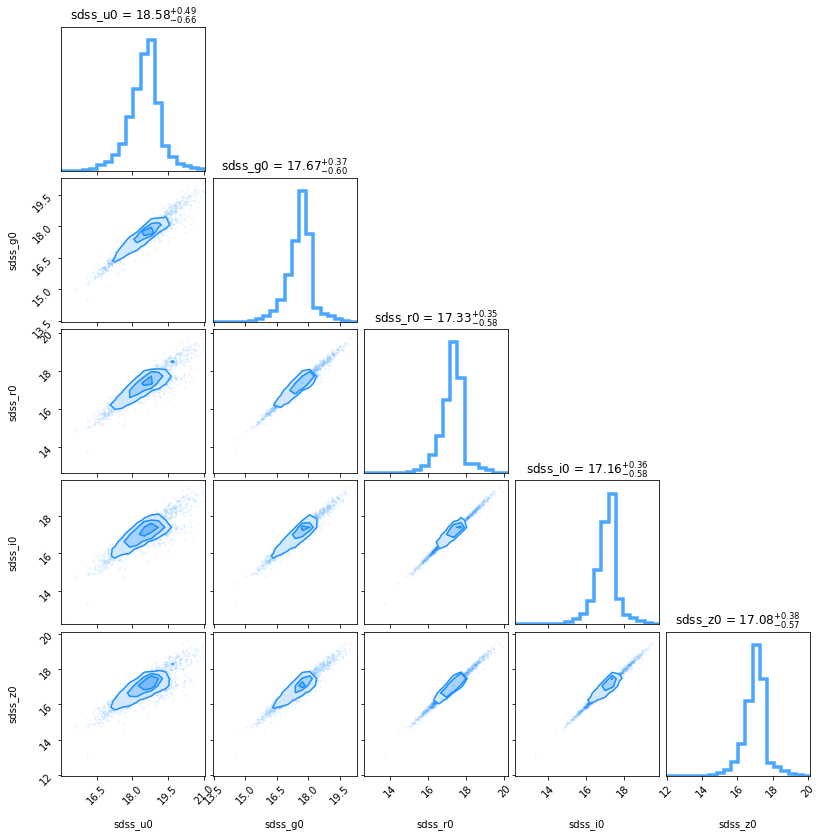

In [58]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [59]:
X_train, X_vali = train_test_split(X_data, test_size=0.05)
Y_train = torch.ones(len(X_train), 11)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

### now we provide the redshift distribution to it

In [60]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

seed = 2
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)[:-1]
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 30), 
                   np.abs(np.random.normal(size=len(_bounds)) / 30)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name='NMF',
                                              num_transforms=15, #10,  # 10
                                              num_bins=40,  # how smashed it is. 10
                                              hidden_features=150, #50, # 200 #100  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [61]:
NDE_theta.build(
    Y_train[:, :-1],
    X_train,
    filterset=filters,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

NDE_theta.external_redshift_data = z_nsa

[ 0.00017925  0.00015401 -0.03130589 -0.01465221 -0.02709767 -0.01222522
 -0.01320175  0.00845089 -0.01722763 -0.02213505]
Total number of params in the model: 2721825


(array([457., 583., 879., 890., 620., 290., 144.,  77.,  43.,  43.]),
 array([0.01000618, 0.0144954 , 0.01898463, 0.02347386, 0.02796309,
        0.03245232, 0.03694154, 0.04143077, 0.04592   , 0.05040922,
        0.05489845], dtype=float32),
 <BarContainer object of 10 artists>)

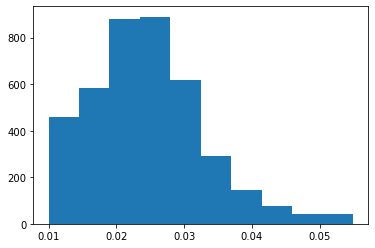

In [62]:
plt.hist(z_nsa)

In [63]:
max_epochs = 5
blurs = [0.2, 0.1, 0.1, 0.1, 0.1]# * 4
# max_epochs = 2
# blurs = []

scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-3, #5e-4,
                                                steps_per_epoch=100,
                                                epochs=max_epochs)
for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    
    NDE_theta.train(n_epochs=100,
                    speculator=speculator,
                    only_penalty=False,
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={
                        'p': 2, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 3.9999999999999996e-05


Loss = 0.889 (train), 0.077 (vali), 0.000 (bad ratio): 100%|██| 100/100 [00:56<00:00,  1.78epochs/s]


    Epoch 1
    lr: 0.0007658192103303784


Loss = 0.255 (train), 0.240 (vali), 0.000 (bad ratio): 100%|██| 100/100 [00:57<00:00,  1.74epochs/s]


    Epoch 2
    lr: 0.0009485192531172955


Loss = 0.232 (train), 0.255 (vali), 0.000 (bad ratio): 100%|██| 100/100 [00:56<00:00,  1.77epochs/s]


    Epoch 3
    lr: 0.0006068821499737472


Loss = 0.096 (train), 0.232 (vali), 0.000 (bad ratio): 100%|██| 100/100 [00:57<00:00,  1.75epochs/s]


    Epoch 4
    lr: 0.00018476211394223113


Loss = 0.203 (train), 0.263 (vali), 0.000 (bad ratio): 100%|██| 100/100 [00:56<00:00,  1.77epochs/s]


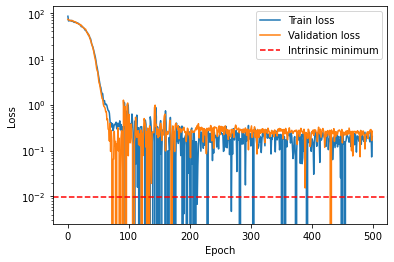

In [64]:
NDE_theta.plot_loss(min_loss=intr_loss)
plt.yscale('log')

In [65]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

# NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
# NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 122
Best train loss: 0.330605149269104
Best vali loss: -0.0934516191482544


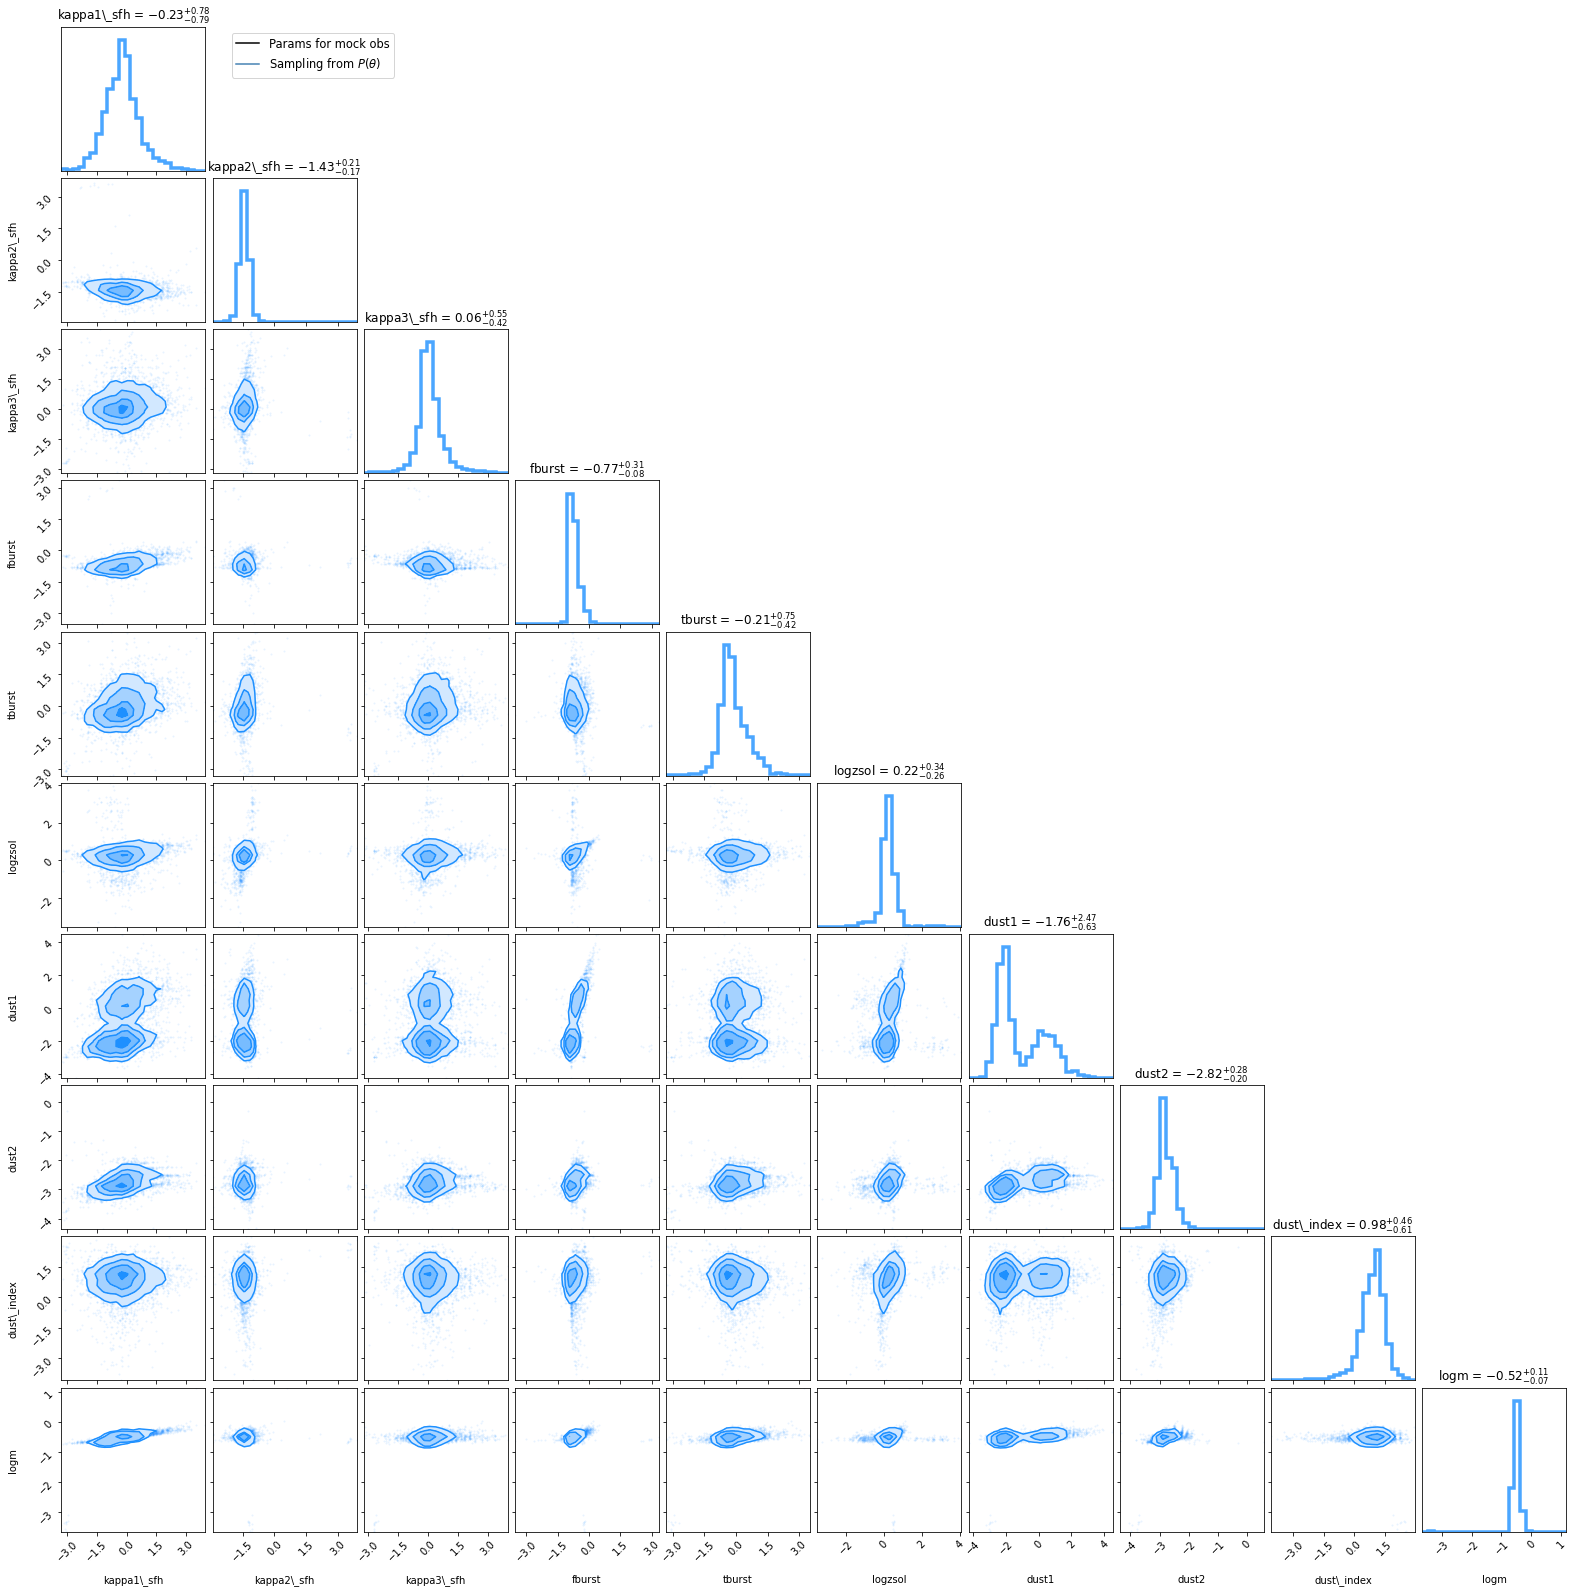

In [66]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name[:-2] + speculator.params_name[-1:]]

figure = corner.corner(samples.cpu().detach().numpy(), 
                  labels=labels, bins=25,
                  color='dodgerblue',
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = figure.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

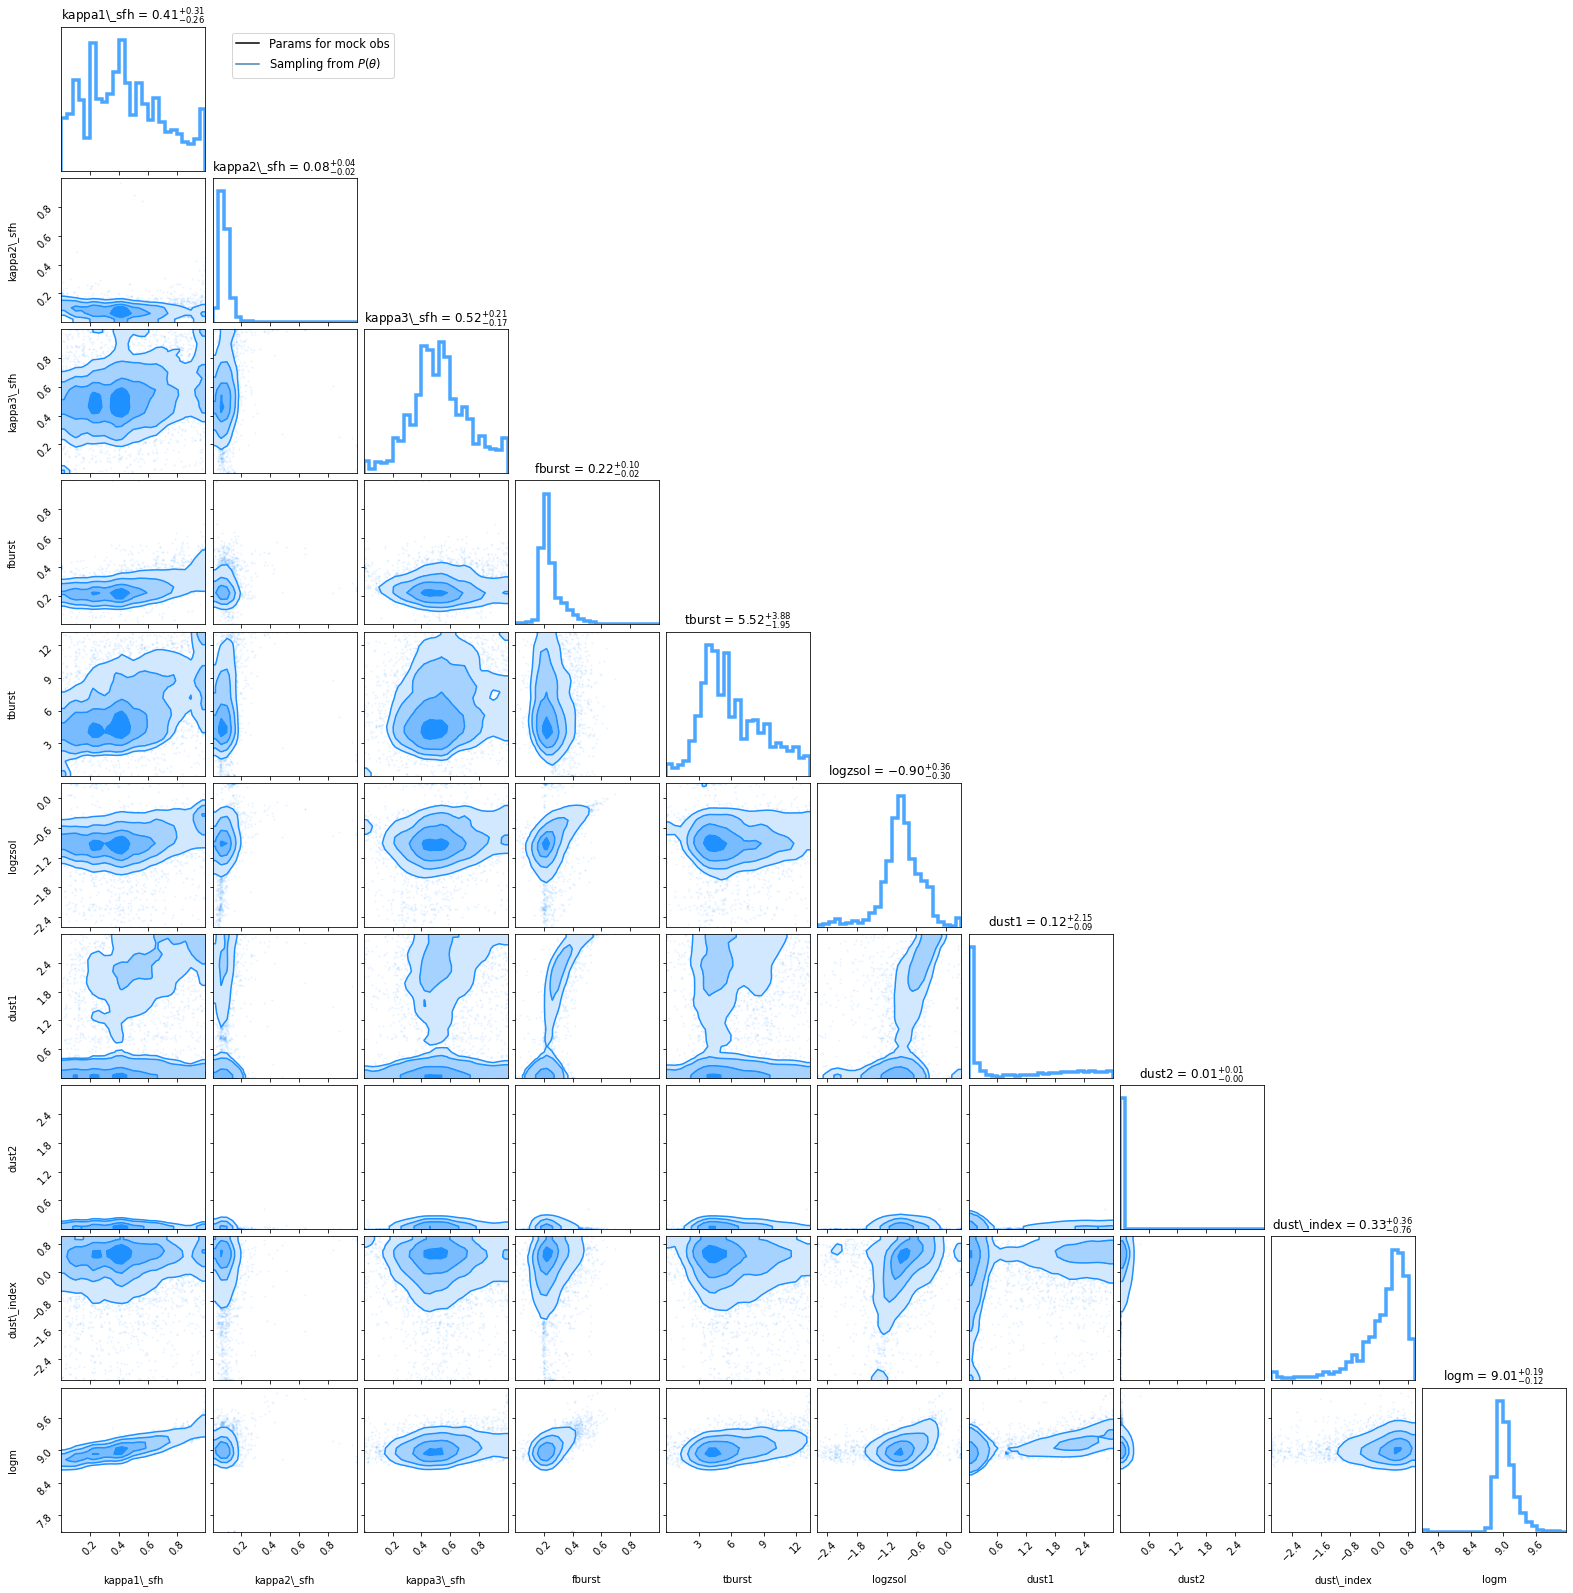

In [67]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name[:-2] + speculator.params_name[-1:]]

# figure = corner.corner(inverse_transform_nmf_params(Y_truth_tr, _prior_NDE).cpu().detach().numpy(), 
#                        color='dimgray', labels=labels, bins=25,
#                        smooth=1, fill_contours=True,
#                        show_titles=True, title_kwargs={"fontsize": 12}, 
#                        hist_kwargs={'density': True})

nf_plot = corner.corner(inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).cpu().detach().numpy(), 
#                       fig=figure, 
                        labels=labels, bins=25,
                      color='dodgerblue',
                      smooth=1, fill_contours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

(array([1.000e+00, 0.000e+00, 3.000e+00, 2.200e+01, 6.700e+01, 1.650e+02,
        3.490e+02, 5.930e+02, 1.046e+03, 1.780e+03]),
 array([7.5802293, 7.772197 , 7.964164 , 8.156132 , 8.348099 , 8.540066 ,
        8.732034 , 8.924001 , 9.115968 , 9.307936 , 9.499903 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

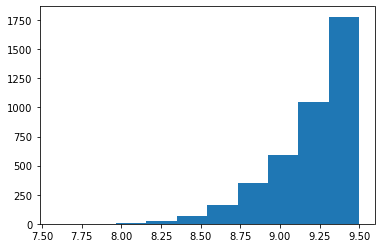

In [26]:
plt.hist(nsa_logm[nsa_logm < 9.5])

In [27]:
_spl = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior)
# _z = torch.Tensor(np.random.choice(NDE_theta.external_redshift_data, len(_spl))[
#     :, None]).to(NDE_theta.device)

# _z = torch.Tensor(np.random.normal(0.008, 0.002, len(_spl))[
#     :, None]).to(NDE_theta.device)
_z = torch.Tensor(np.random.choice(NDE_theta.external_redshift_data, len(_spl))[
    :, None]).to(NDE_theta.device)
_spl = torch.hstack([_spl[:, :-1], _z, _spl[:, -1:]])


_spl[:, -1] = torch.Tensor(np.random.choice(nsa_logm[nsa_logm < 9.5], size=len(_spl))).to('cuda')

# _spl[:, -1] = torch.Tensor(np.random.normal(9.0, 0.5, size=len(_spl))).to('cuda')

(array([ 593.,  692., 1075., 1118.,  763.,  342.,  192.,  104.,   59.,
          62.]),
 array([0.01000618, 0.0144954 , 0.01898463, 0.02347386, 0.02796309,
        0.03245232, 0.03694154, 0.04143077, 0.04592   , 0.05040922,
        0.05489845], dtype=float32),
 <BarContainer object of 10 artists>)

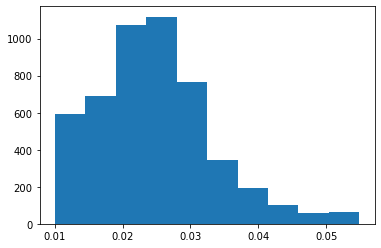

In [28]:
plt.hist(_spl[:, -2].detach().cpu().numpy())

(array([457., 583., 879., 890., 620., 290., 144.,  77.,  43.,  43.]),
 array([0.01000618, 0.0144954 , 0.01898463, 0.02347386, 0.02796309,
        0.03245232, 0.03694154, 0.04143077, 0.04592   , 0.05040922,
        0.05489845], dtype=float32),
 <BarContainer object of 10 artists>)

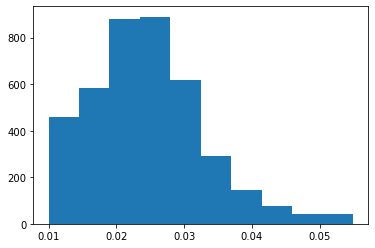

In [29]:
plt.hist(nsa_z[nsa_logm < 9.5])

0 5000
>40 0


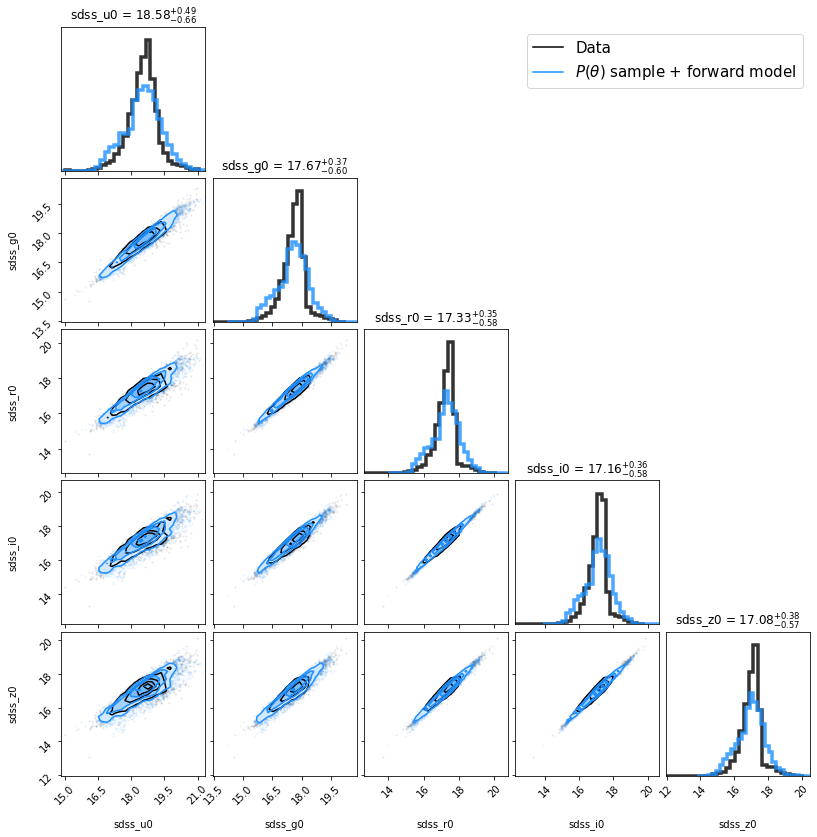

In [68]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       plot_datapoints=True,
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


_spl = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior)
_z = torch.Tensor(np.random.choice(NDE_theta.external_redshift_data, len(_spl))[
    :, None]).to(NDE_theta.device)
_spl = torch.hstack([_spl[:, :-1], _z, _spl[:, -1:]])

mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [108]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_z = np.random.choice(NDE_theta.external_redshift_data, len(_samples_unt))[
    :, None]
_samples_unt = np.hstack([_samples_unt[:, :-1], _z, _samples_unt[:, -1:]])

_samples = np.hstack([_samples_unt[:, -1:], 
               prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]), 
               _samples_unt[:, 3:-1]])

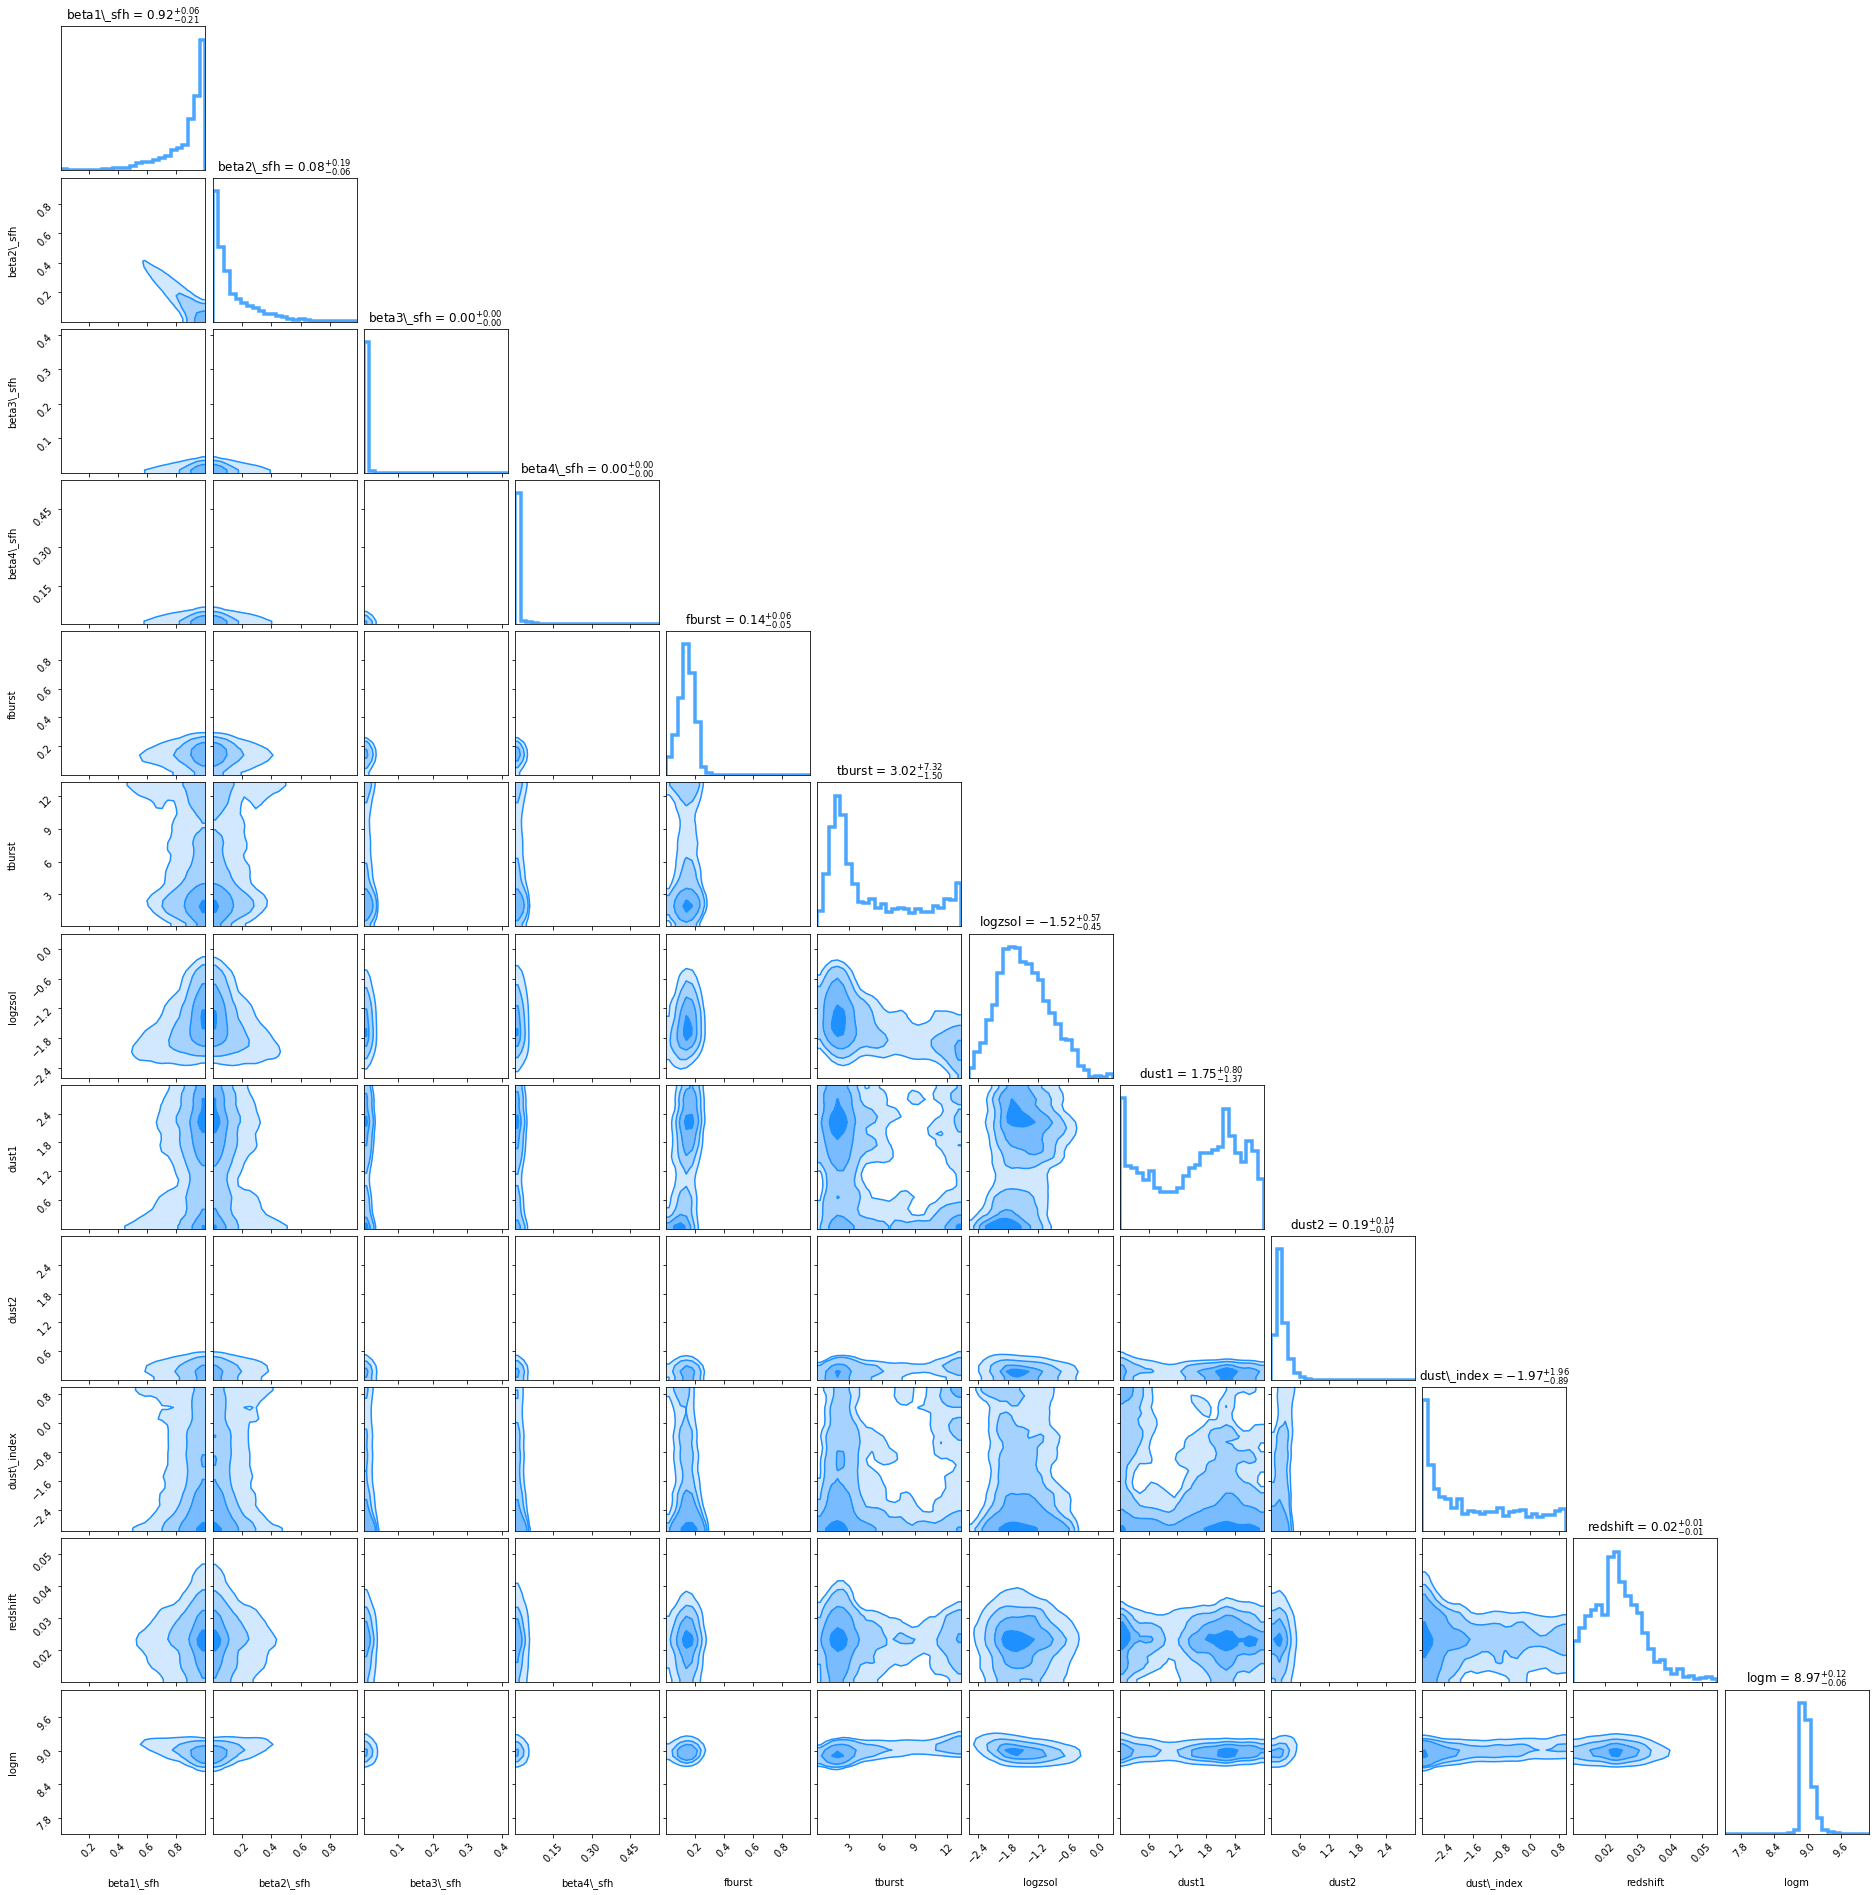

In [109]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]


# Distribution of beta coeffs
y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

nf_plot = corner.corner(y_truth_trans, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [142]:
NDE_theta.penalty_powers = [10] * 11

In [144]:
n_samples = len(NDE_theta.X.detach())

L = SamplesLoss(loss="sinkhorn", **{'p': 1, 'blur': 0.1, 'scaling': 0.8})


NDE_theta.optimizer.param_groups[0]['lr'] = 1e-6
NDE_theta.optimizer.zero_grad()
loss, bad_ratio = NDE_theta._get_loss_NMF(NDE_theta.X.detach(), speculator, n_samples,
                                 noise, None, noise_model_dir, L)
print(loss, bad_ratio)
loss.backward()
# NDE_theta.optimizer.step()
#     NDE_theta.sample(1)

Bad mask num tensor(3296, device='cuda:0')
Number of inf: tensor(0, device='cuda:0')
tensor(14.0700, device='cuda:0', grad_fn=<AddBackward0>) tensor(13.3888, device='cuda:0', grad_fn=<MeanBackward0>)


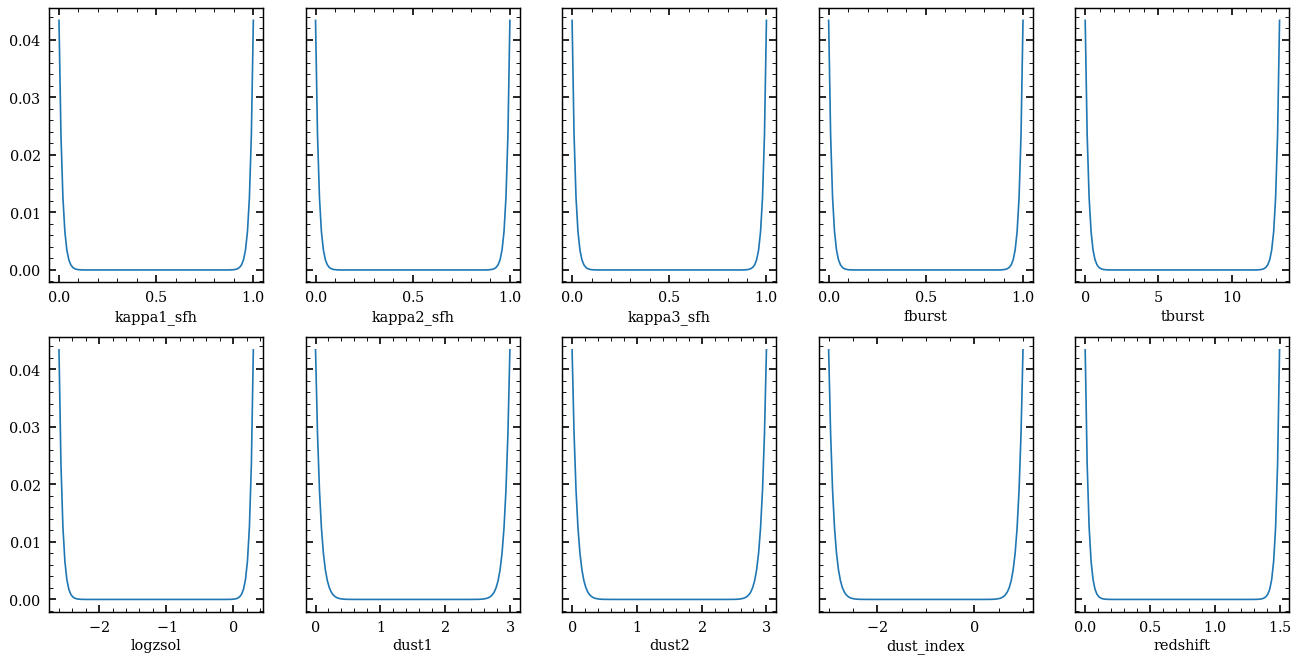

In [209]:
#### Plot the penalty

from popsed.nde import fuzzy_logic_prior

bounds = torch.Tensor(NDE_theta.bounds)

powers = NDE_theta.penalty_powers # [10] * 11
# [50] * 3 + [50] * 2 + [50] + [30] * 3 + [50] * 2
width = (bounds[:, 1] - bounds[:, 0]) / 2
loc = (bounds[:, 1] + bounds[:, 0]) / 2
index = torch.ones_like(loc) * 3

fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)
for i in range(10):
    plt.sca(axes[i//5, i%5])
    par = torch.linspace(*bounds[i], 100)
    _penalty = fuzzy_logic_prior(par, loc[i], 10 ** (index[i] / powers[i]) * width[i], powers[i])
    plt.plot(par.cpu().numpy(), _penalty.cpu().numpy())
    plt.xlabel(NDE_theta.params_name[i])
    
plt.subplots_adjust(hspace=0.2)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [6]:
params = np.load('./nsa_sedflow/params_posterior.npy')
params = params[np.random.randint(0, len(params), 15000)]

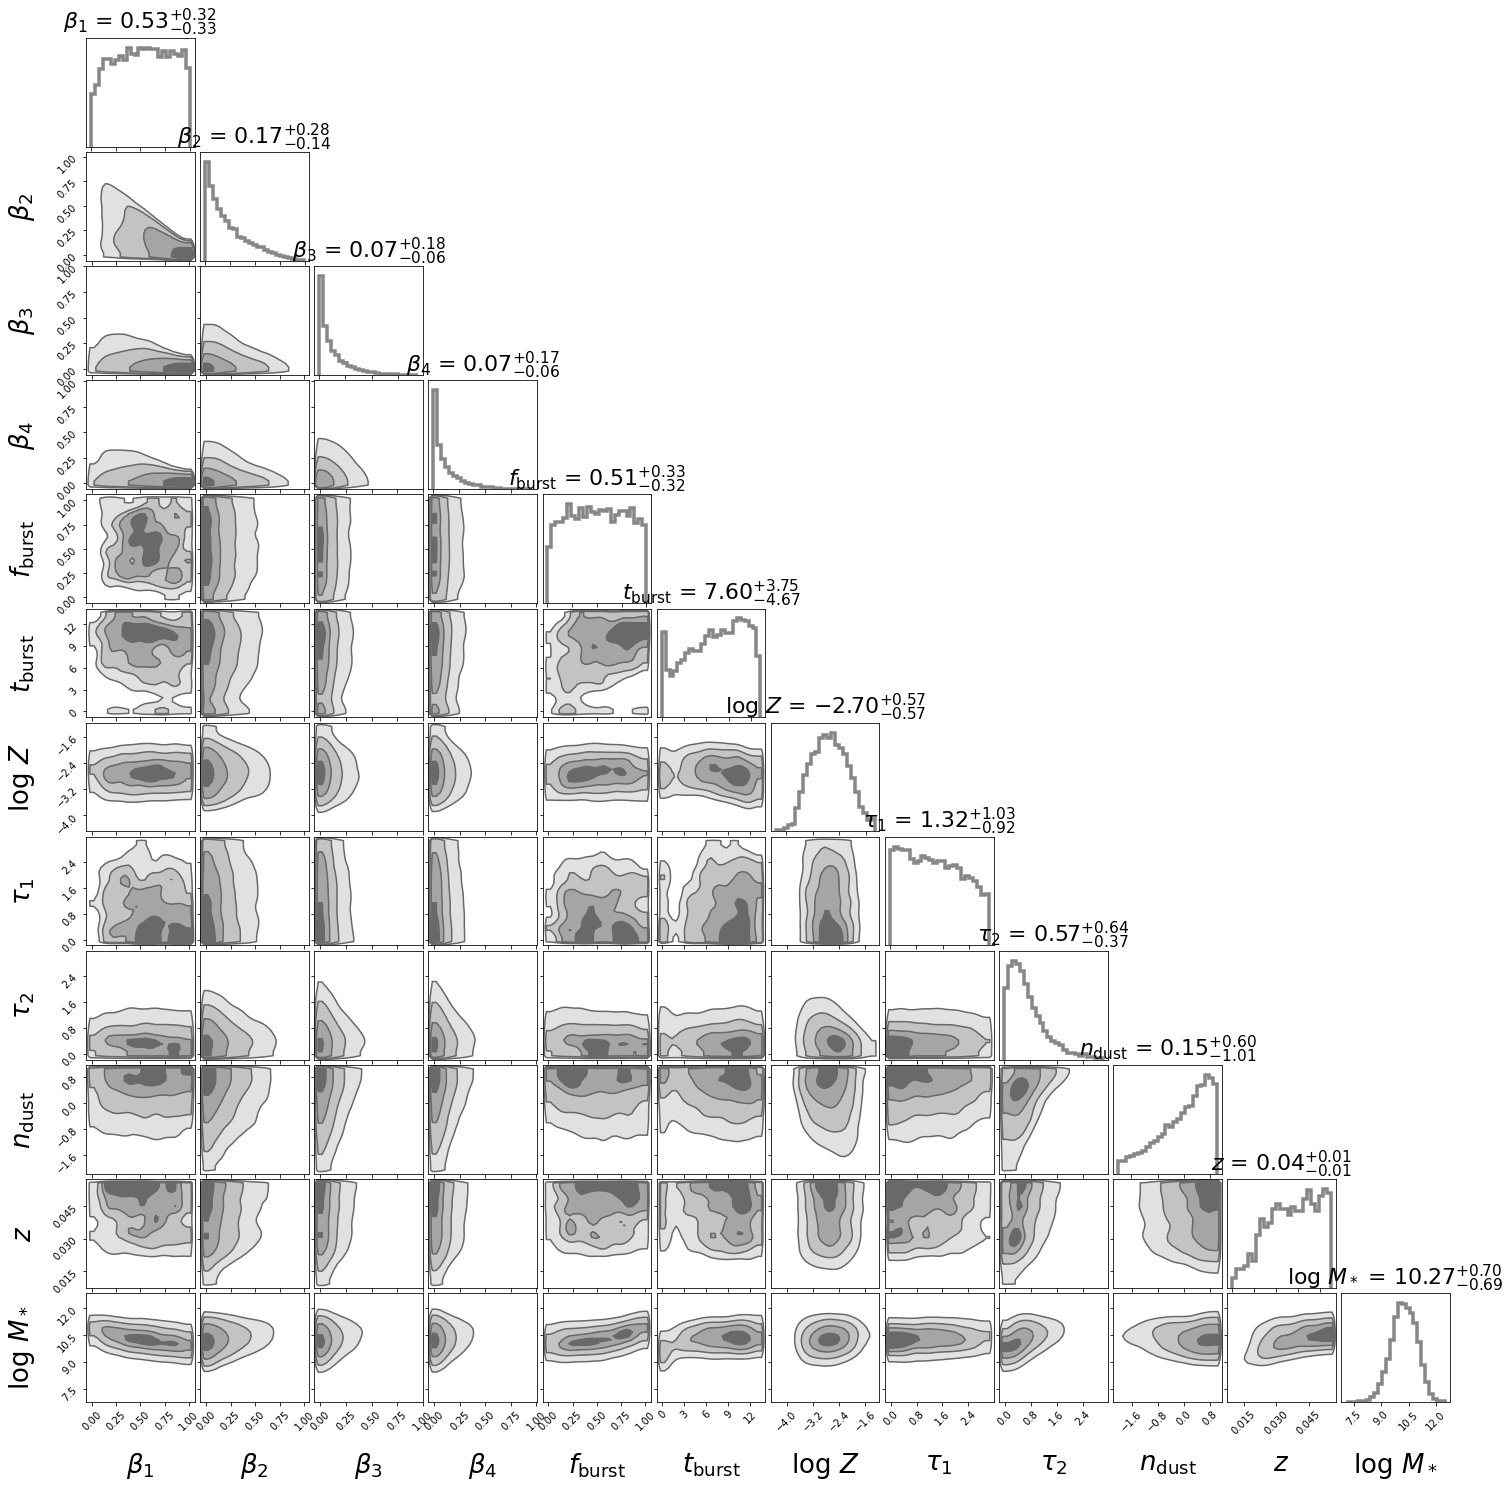

In [40]:
import matplotlib.lines as mlines

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    params,
    fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=1.5,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

In [7]:
params = np.hstack([prior.FlatDirichletPrior(4).untransform(params[:, 0:4]), params[:, 4:]])

In [8]:
params.shape

(15000, 11)

In [29]:
torch.cuda.empty_cache()

In [19]:
_mag = speculator._predict_mag_with_mass_redshift(
                    params,
                    noise=noise, SNR=None, noise_model_dir=noise_model_dir)

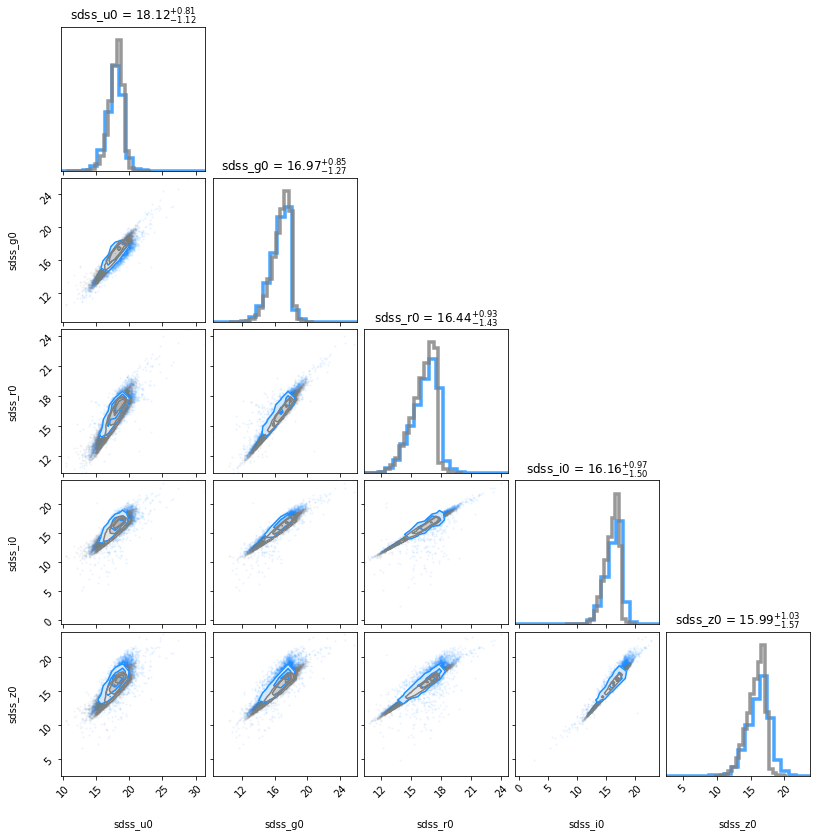

In [20]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(_mag.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

figure = corner.corner(mags_nsa,
                       fig=figure,
                       color='gray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [23]:
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 1e-3, 'scaling': 0.9})
print("Intrinsic sampling loss:", L(torch.Tensor(mags_nsa[:5000]).to('cuda'), _mag[:5000]).item())

Intrinsic sampling loss: 0.8318371176719666
